In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from cemba_data.tools.integration.utilities import calculate_direct_confusion
from ALLCools.plot import *
from ALLCools.plot.color import plot_colorbar
import xarray as xr

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

## Cell Meta

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

## Integration result

In [5]:
mc_integration_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/IntegrationWithATAC/HPF-Exc/Integration/mc_cell_tidy_data.with_integration_info.msg'
)

atac_integration_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/IntegrationWithATAC/HPF-Exc/Integration/atac_cell_tidy_data.with_integration_info.msg'
)

In [6]:
atac_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/ATAC/Metadata/ATAC.cell_tidy_data.v2.msg')
atac_sub_type_palette = atac_tidy_data.groupby('SubType')['L3Color'].apply(lambda i: i[0]).to_dict()

## mC

In [7]:
cfm = calculate_direct_confusion(mc_integration_data[['SubType', 'co_cluster']], 
                                 atac_integration_data[['SubType', 'co_cluster']])

In [9]:
# reorder cfm
row_order = [
    'CA1 Chrm3',
    'CA1 Ptprg',
    'CA1 Ak5',
    'CA3 Efnb2',
    'CA1 Kif26a',
    'Gfra1 Gfra1',
    'CA1 Lingo2',
    'CA3-St18 Epha5',
    'CA3-St18 Nuak1',
    'CA3-St18 Tead1',
    'CA3 Cadm2',
    'IG-CA2 Peak1',
    'IG-CA2 Chrm3',
    'IG-CA2 Xpr1',
    'DG-po Bcl11a',
    'DG-po Calb2',
    'DG-po Kctd8',
    'DG dg-all',
]

col_order = [
    'Glutamate.CA1.CA1c1',
    'Glutamate.CA1.CA1c2',
    'Glutamate.CA3.CA2c4',
    'Glutamate.CA1.CA1c3',
    'Glutamate.L2HIP.L2HIPc3',
    'Glutamate.L2HIP.L2HIPc2',
    'Glutamate.L2HIP.L2HIPc1',
    'Glutamate.CA3.CA2c2',
    'Glutamate.CA3.CA2c1',
    'Glutamate.CA3.CA2c3',
    'Glutamate.CA3.CA2c5',
    'Glutamate.CA3.CA2c6',
    'Glutamate.GC.DG',
]

cfm = cfm.loc[row_order, col_order]

In [10]:
# prepare legend
from matplotlib.colors import LinearSegmentedColormap

row_legend_data = []
row_legend_color = []

for i, cluster in enumerate(cfm.index):
    row_legend_data.append(i)
    row_legend_color.append(sub_type_palette[cluster])
row_legend_palette = LinearSegmentedColormap.from_list('mc', row_legend_color)

col_legend_data = []
col_legend_color = []

for i, cluster in enumerate(cfm.columns):
    col_legend_data.append(i)
    col_legend_color.append(atac_sub_type_palette[cluster])
col_legend_palette = LinearSegmentedColormap.from_list('atac', col_legend_color)

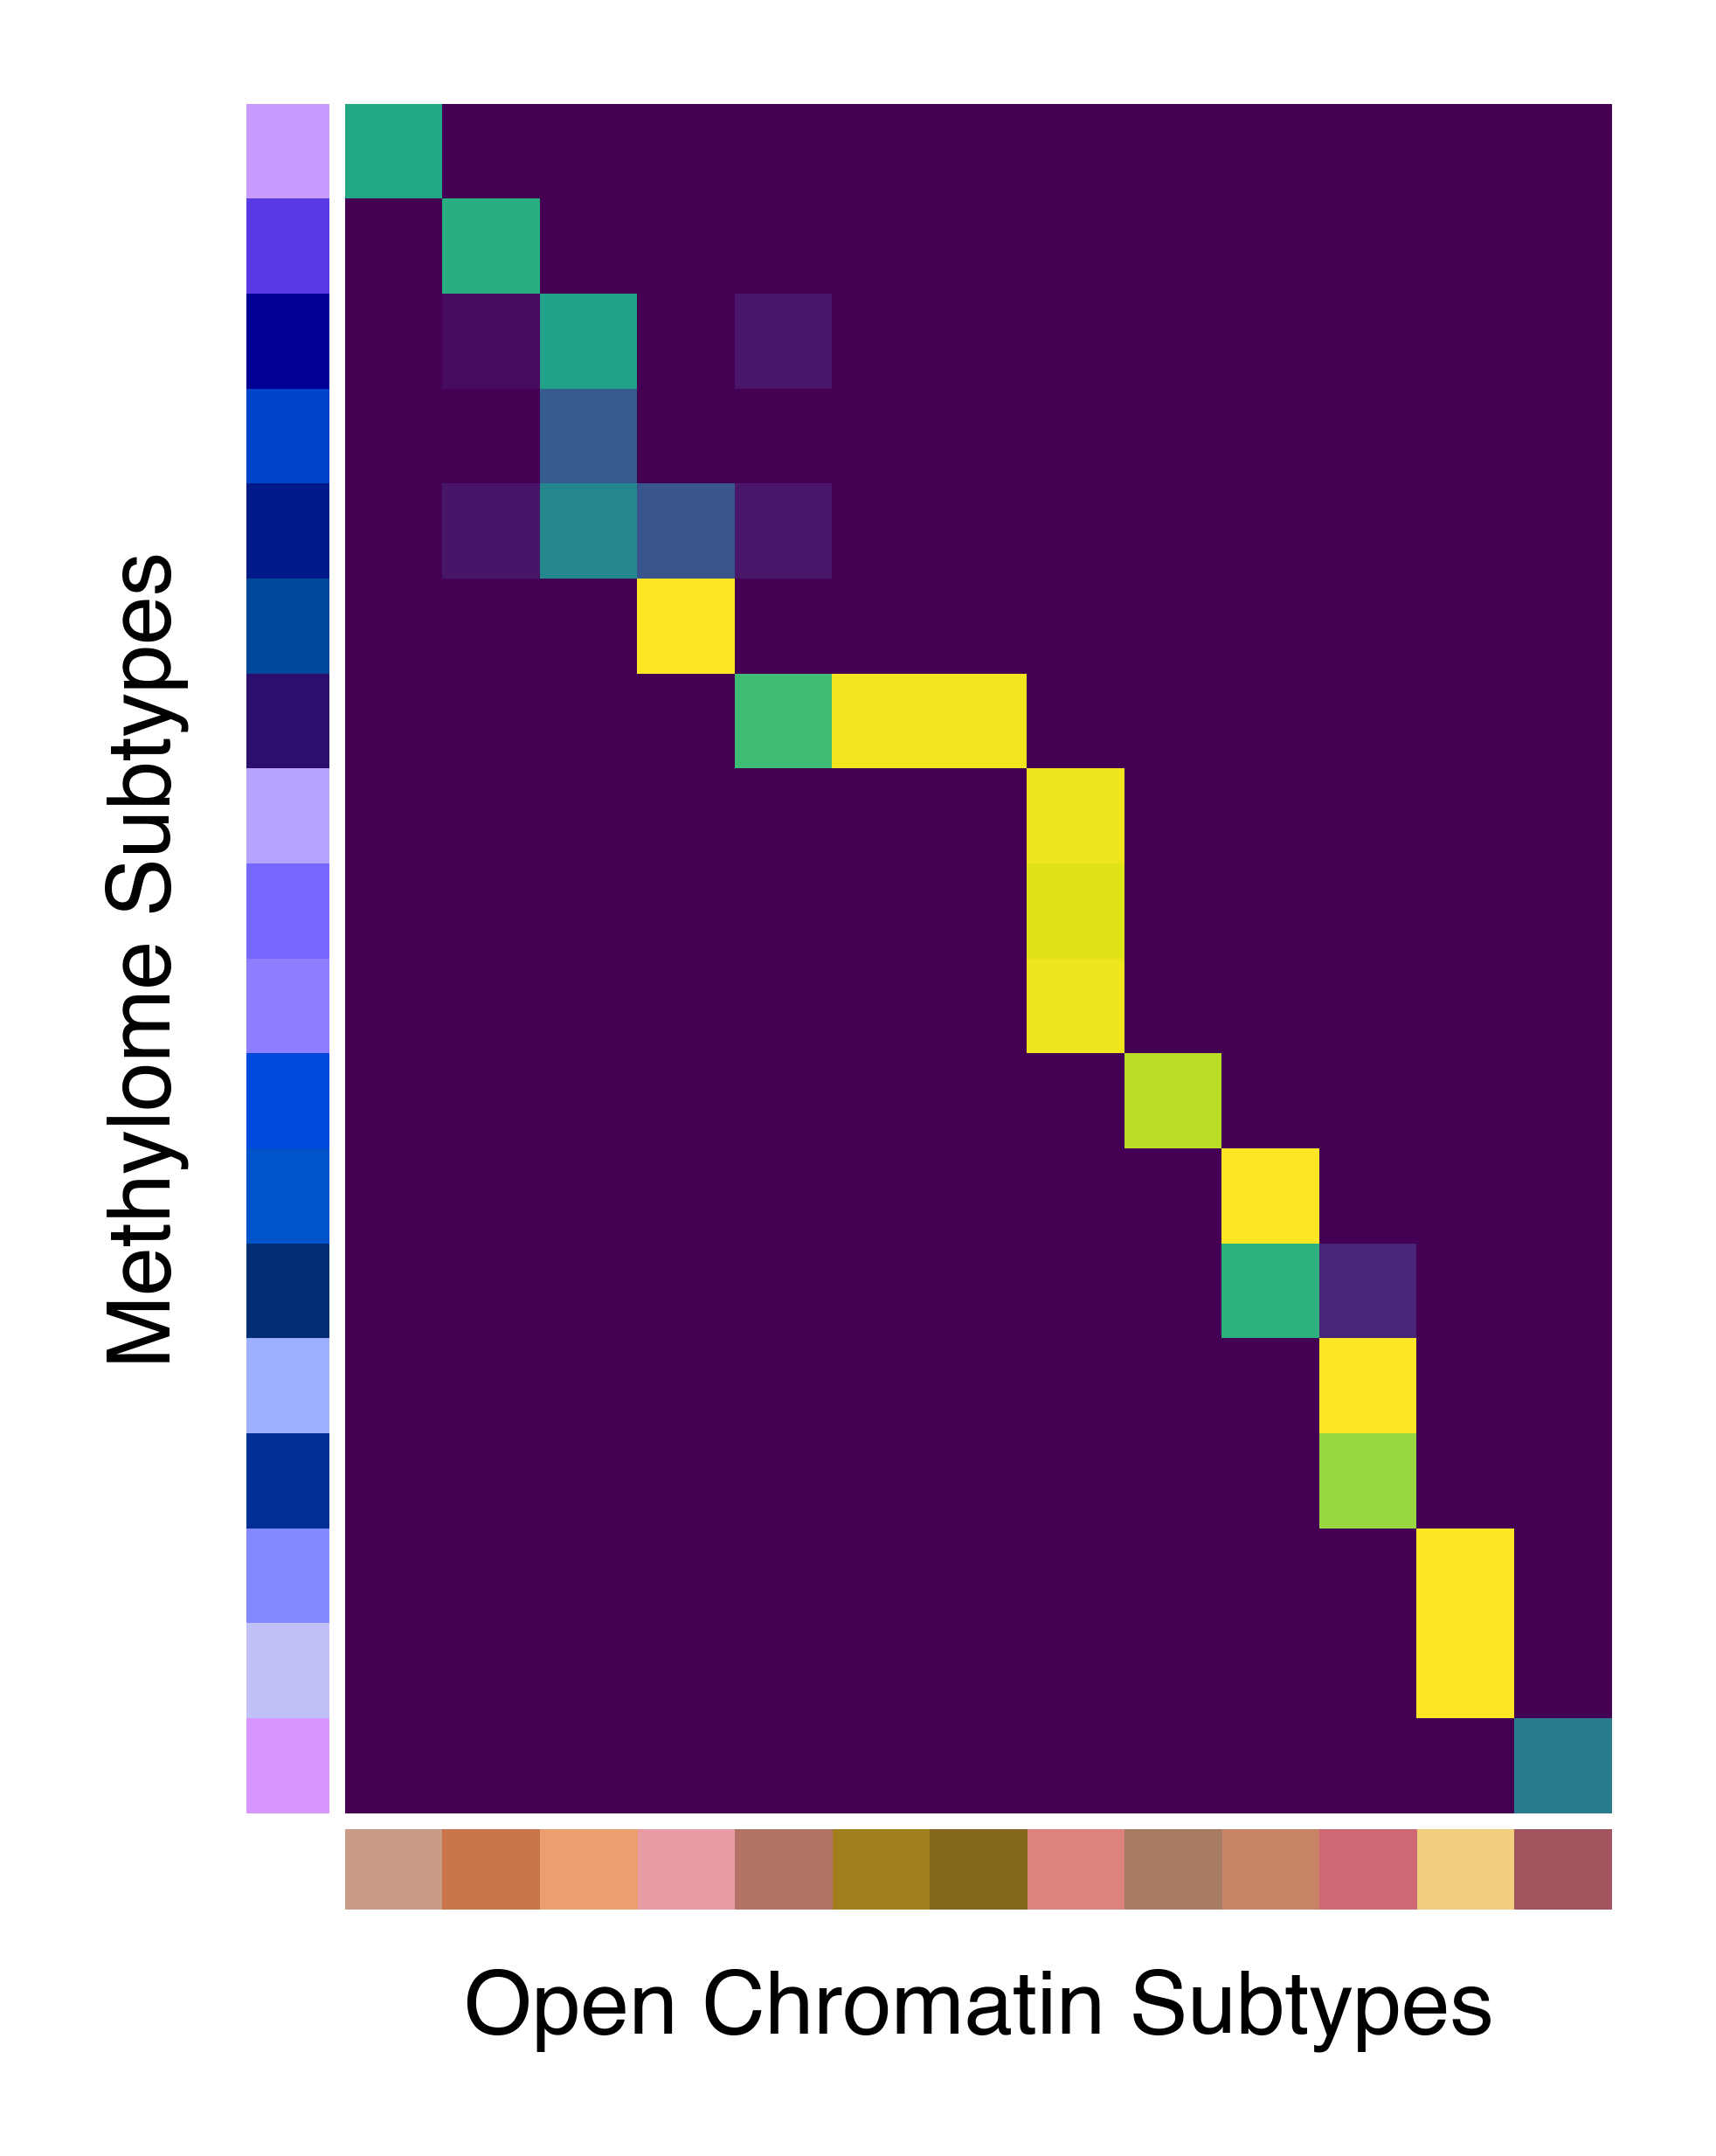

In [12]:
fig = plt.figure(figsize=(14*0.12, 19*0.12), dpi=1200)
gs = fig.add_gridspec(19, 14)

# heatmap
ax_heatmap = fig.add_subplot(gs[:-1, 1:])
sns.heatmap(cfm, cbar=False, ax=ax_heatmap, 
            cmap='viridis', vmin=0.2, vmax=1)
ax_heatmap.set(xticks=[], yticks=[], xlabel='', ylabel='')

# row legend
ax_row_legend = fig.add_subplot(gs[:-1, :1])
ax_row_legend.imshow(np.array(row_legend_data).reshape(len(row_legend_data), 1),
                     cmap=row_legend_palette, aspect='auto')
ax_row_legend.set_ylabel('Methylome Subtypes', fontsize=labelsize)
ax_row_legend.set(xticks=[], yticks=[])
sns.despine(ax=ax_row_legend, left=True, bottom=True)

# col legend
ax_col_legend = fig.add_subplot(gs[-1:, 1:])
ax_col_legend.imshow(np.array(col_legend_data).reshape(1, len(col_legend_data)), 
                     cmap=col_legend_palette, aspect='auto')
ax_col_legend.set_xlabel('Open Chromatin Subtypes', fontsize=labelsize)
ax_col_legend.set(xticks=[], yticks=[])
sns.despine(ax=ax_col_legend, left=True, bottom=True)

fig.savefig('ConfusionMatrix.pdf', bbox_inches='tight')

In [13]:
atac_integration_data.shape

(1757, 10)

In [14]:
mc_integration_data.shape

(13949, 61)

In [18]:
atac_tidy_data['L2cluster'].isin(['Glutamate.L2HIP', 'Glutamate.GC', 'Glutamate.CA3',
       'Glutamate.CA1']).sum()

96755

In [19]:
96755 / 1757

55.068298235628916